## Signal-To-Noise-Ratio/ Missing Data/ Concept Drifts


In [1]:
from kafka import KafkaProducer
import time
import datetime
import json
import numpy as np
import random
from utils.kafka_sender import plot_sens_obs, plot_drift_stream
from schemas.schema_sensor import SensorParams, DriftParams

In [2]:
NOISE_LEVEL=0  # Set NOISE LEVEL

params_sens1 = SensorParams(sensor_name="sensor-1",
                            mu=2,
                            sigma=2,
                            eps=NOISE_LEVEL,
                            max_delay=0.1,
                            )

params_sens2 = SensorParams(sensor_name="sensor-2",
                            mu=3,
                            sigma=2,
                            eps=NOISE_LEVEL,
                            max_delay=0.1,
                            )

params_sens3 = SensorParams(sensor_name="sensor-3",
                            mu=1,
                            sigma=2,
                            eps=NOISE_LEVEL,
                            max_delay=0.1,
                            )

In [3]:
producer = KafkaProducer(bootstrap_servers='localhost:9092', 
                         value_serializer=lambda v: json.dumps(v).encode('utf-8'))

## Desired signal

In [4]:
from utils.kafka_sender import generator_streaming_data

NUM_OBS = 300

list_signal_obs_1=[]
list_signal_obs_2=[]
list_signal_obs_3=[]

unbounded_data = generator_streaming_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    data = next(unbounded_data)
    list_signal_obs_1.append(data["sensor_1"]["obs"])
    list_signal_obs_2.append(data["sensor_2"]["obs"])
    list_signal_obs_3.append(data["sensor_3"]["obs"])

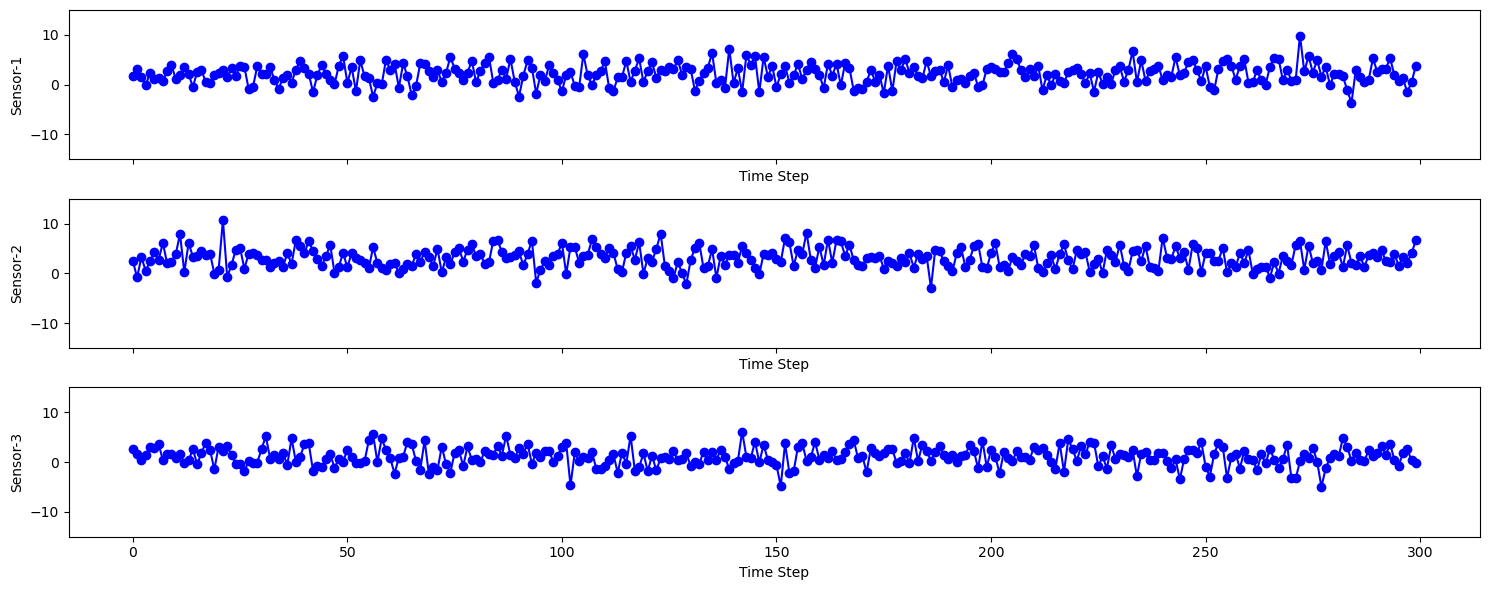

In [5]:
from utils.kafka_sender import plot_sens_obs

obs_data_stream = np.array([list_signal_obs_1, list_signal_obs_2, list_signal_obs_3])

# plot sensor observations
y_upper_limit= 15
y_lower_limit= -15
plot_sens_obs(obs_data_stream, ylim_low=y_lower_limit, ylim_up=y_upper_limit)

## Desired signal + background noise

In [6]:
# Add background noise
NOISE_LEVEL=2

params_sens1.eps = NOISE_LEVEL
params_sens2.eps = NOISE_LEVEL
params_sens3.eps = NOISE_LEVEL

In [7]:
list_noisy_obs_1=[]
list_noisy_obs_2=[]
list_noisy_obs_3=[]

unbounded_noisy_data = generator_streaming_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    noisy_data = next(unbounded_noisy_data)
    list_noisy_obs_1.append(noisy_data["sensor_1"]["obs"])
    list_noisy_obs_2.append(noisy_data["sensor_2"]["obs"])
    list_noisy_obs_3.append(noisy_data["sensor_3"]["obs"])

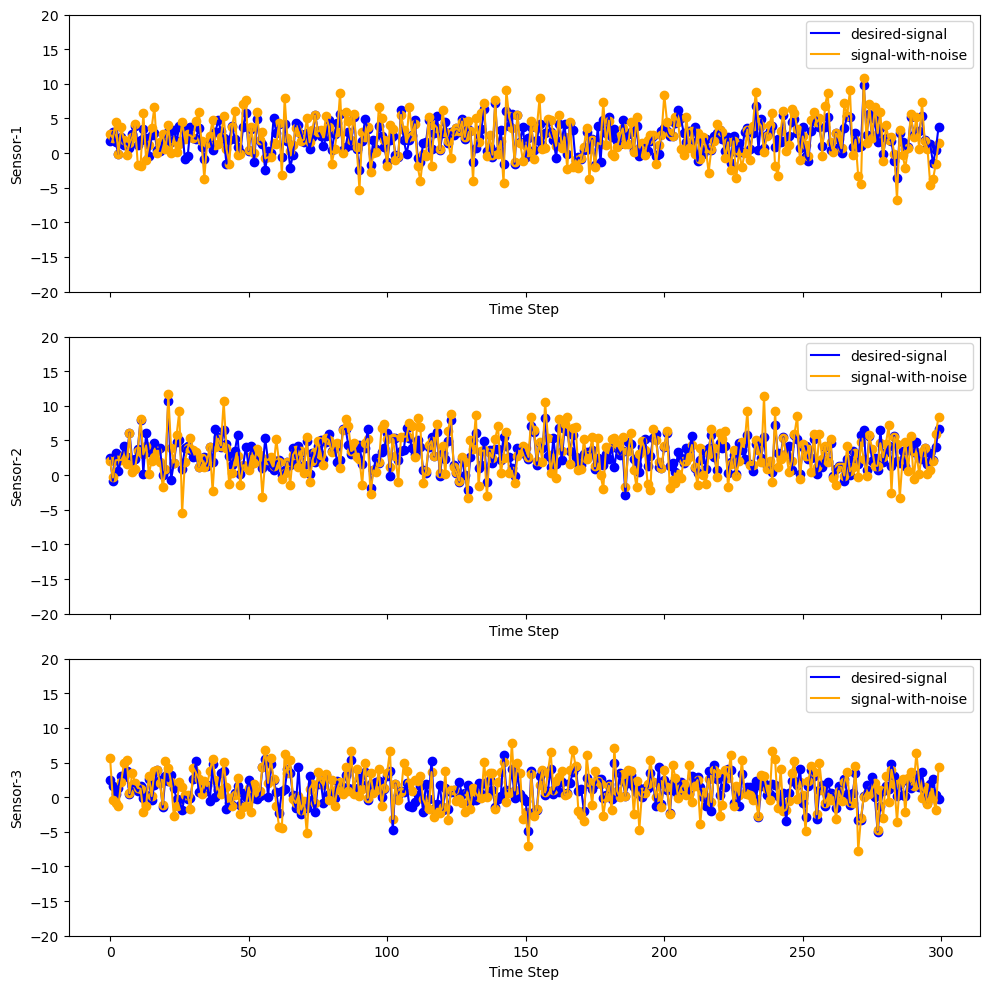

In [8]:
import matplotlib.pyplot as plt

noisy_obs_data_stream = np.array([list_noisy_obs_1, list_noisy_obs_2, list_noisy_obs_3])

noise_levels = {"signal": obs_data_stream,
                f"noise-level-{NOISE_LEVEL}": noisy_obs_data_stream}

fig, axes = plt.subplots(nrows=len(obs_data_stream), ncols=1, figsize=(10, 10), sharex=True)
for idx, ax in enumerate(axes):
    ax.plot(np.arange(len(obs_data_stream[idx])), noise_levels["signal"][idx], color="blue", label="desired-signal")
    ax.scatter(np.arange(len(obs_data_stream[idx])), noise_levels["signal"][idx], color="blue")
    ax.plot(np.arange(len(obs_data_stream[idx])), noise_levels[f"noise-level-{NOISE_LEVEL}"][idx], color="orange", label="signal-with-noise")
    ax.scatter(np.arange(len(obs_data_stream[idx])), noise_levels[f"noise-level-{NOISE_LEVEL}"][idx], color="orange")
    ax.set_ylabel(f"Sensor-{idx + 1}")
    ax.set_xlabel("Time Step")
    ax.set_ylim(-20, 20)
    ax.legend()
plt.tight_layout()
plt.show()

## Desired signal + background noise + missing values

In [9]:
# Add percentage missing data
MISSING_DATA_PERCENTAGE = 0.1  # 10% missing data

params_sens1.eps_nan = MISSING_DATA_PERCENTAGE
params_sens2.eps_nan = MISSING_DATA_PERCENTAGE
params_sens3.eps_nan = MISSING_DATA_PERCENTAGE

In [10]:
list_missing_obs_1=[]
list_missing_obs_2=[]
list_missing_obs_3=[]

unbounded_missing_data = generator_streaming_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    missing_data = next(unbounded_missing_data)
    list_missing_obs_1.append(missing_data["sensor_1"]["obs"])
    list_missing_obs_2.append(missing_data["sensor_2"]["obs"])
    list_missing_obs_3.append(missing_data["sensor_3"]["obs"])

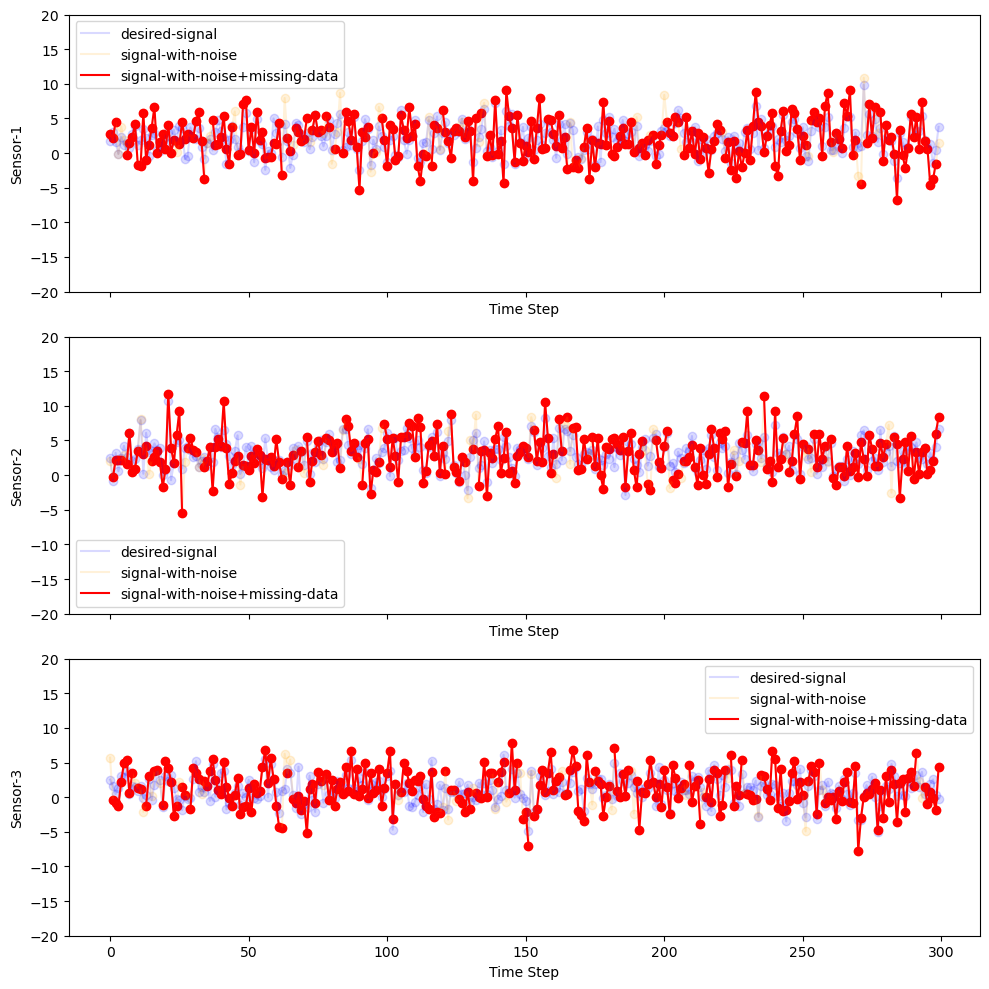

In [11]:
missing_obs_data_stream = np.array([list_missing_obs_1, list_missing_obs_2, list_missing_obs_3])

missing_levels = {"signal": obs_data_stream,
                    f"noise-level-{NOISE_LEVEL}": noisy_obs_data_stream,
                    f"missing-data-{MISSING_DATA_PERCENTAGE}": missing_obs_data_stream}

TRANSPARENCY =0.15
fig, axes = plt.subplots(nrows=len(obs_data_stream), ncols=1, figsize=(10, 10), sharex=True)
for idx, ax in enumerate(axes):
    ax.plot(np.arange(len(obs_data_stream[idx])), missing_levels["signal"][idx], alpha=TRANSPARENCY , color="blue", label="desired-signal")
    ax.scatter(np.arange(len(obs_data_stream[idx])), missing_levels["signal"][idx], alpha=TRANSPARENCY , color="blue")
    ax.plot(np.arange(len(obs_data_stream[idx])), missing_levels[f"noise-level-{NOISE_LEVEL}"][idx], alpha=TRANSPARENCY , color="orange", label="signal-with-noise")
    ax.scatter(np.arange(len(obs_data_stream[idx])), missing_levels[f"noise-level-{NOISE_LEVEL}"][idx], alpha=TRANSPARENCY , color="orange")
    ax.plot(np.arange(len(obs_data_stream[idx])), missing_levels[f"missing-data-{MISSING_DATA_PERCENTAGE}"][idx], color="red", label="signal-with-noise+missing-data")
    ax.scatter(np.arange(len(obs_data_stream[idx])), missing_levels[f"missing-data-{MISSING_DATA_PERCENTAGE}"][idx], color="red")
    ax.set_ylabel(f"Sensor-{idx + 1}")
    ax.set_xlabel("Time Step")
    ax.set_ylim(-20, 20)
    ax.legend()
plt.tight_layout()
plt.show()

## Desired signal + background-noise + missing-values + concept-drifts

In [12]:
drift_events_sens_1 = [
                        {"drift-event": DriftParams(mu_drift=20, 
                                                    t0_drift=10, 
                                                    duration_drift=40)},
                        ]

drift_events_sens_2 = [
                        {"drift-event": DriftParams(mu_drift=20, 
                                                    t0_drift=50,
                                                    duration_drift=90)},
                        ]

drift_events_sens_3 = [
                        {"drift-event": DriftParams(mu_drift=-15, t0_drift =50, duration_drift=75)}
                      ]

In [13]:
params_sens1.drifts = drift_events_sens_1
params_sens2.drifts = drift_events_sens_2
params_sens3.drifts = drift_events_sens_3

In [14]:
list_drift_obs_1=[]
list_drift_obs_2=[]
list_drift_obs_3=[]

unbounded_drift_data = generator_streaming_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    drift_data = next(unbounded_drift_data)
    list_drift_obs_1.append(drift_data["sensor_1"]["obs"])
    list_drift_obs_2.append(drift_data["sensor_2"]["obs"])
    list_drift_obs_3.append(drift_data["sensor_3"]["obs"])

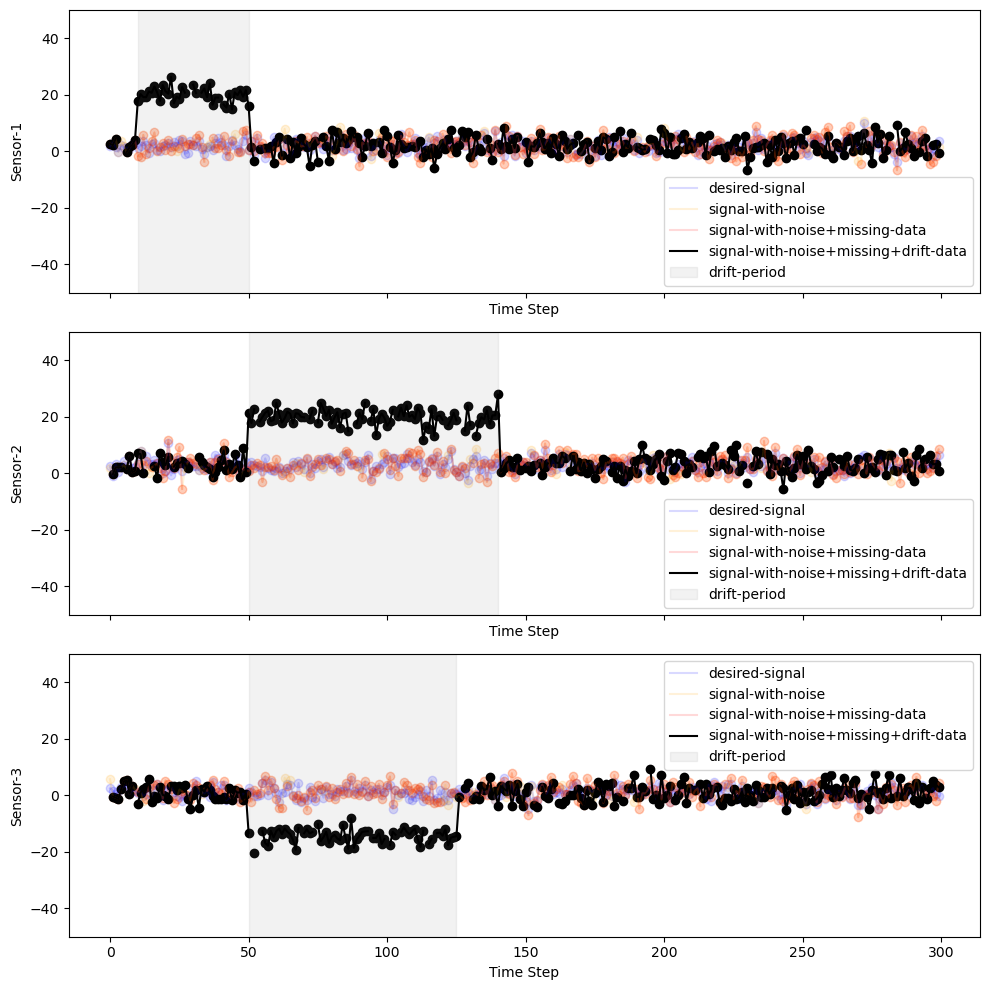

In [15]:
drift_obs_data_stream = np.array([list_drift_obs_1, list_drift_obs_2, list_drift_obs_3])

drift_levels = {"signal": obs_data_stream,
                    f"noise-level-{NOISE_LEVEL}": noisy_obs_data_stream,
                    f"missing-data-{MISSING_DATA_PERCENTAGE}": missing_obs_data_stream,
                    "drift-data":drift_obs_data_stream}

drift_duration = {f"sensor-1": drift_events_sens_1[0]["drift-event"],
                     f"sensor-2": drift_events_sens_2[0]["drift-event"],
                    f"sensor-3": drift_events_sens_3[0]["drift-event"],}

TRANSPARENCY =0.15
fig, axes = plt.subplots(nrows=len(obs_data_stream), ncols=1, figsize=(10, 10), sharex=True)
for idx, ax in enumerate(axes):
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels["signal"][idx], alpha=TRANSPARENCY , color="blue", label="desired-signal")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels["signal"][idx], alpha=TRANSPARENCY , color="blue")
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels[f"noise-level-{NOISE_LEVEL}"][idx], alpha=TRANSPARENCY , color="orange", label="signal-with-noise")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels[f"noise-level-{NOISE_LEVEL}"][idx], alpha=TRANSPARENCY , color="orange")
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels[f"missing-data-{MISSING_DATA_PERCENTAGE}"][idx], alpha=TRANSPARENCY, color="red", label="signal-with-noise+missing-data")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels[f"missing-data-{MISSING_DATA_PERCENTAGE}"][idx], alpha=TRANSPARENCY, color="red")
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels["drift-data"][idx], color="black", label="signal-with-noise+missing+drift-data")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels["drift-data"][idx], color="black")
    t0_drift = drift_duration[f"sensor-{idx + 1}"].t0_drift
    duration_drift = drift_duration[f"sensor-{idx + 1}"].duration_drift
    ax.axvspan(t0_drift, t0_drift + duration_drift, color='gray', alpha=0.1, label='drift-period')
    ax.set_ylabel(f"Sensor-{idx + 1}")
    ax.set_xlabel("Time Step")
    ax.set_ylim(-50, 50)
    ax.legend()
plt.tight_layout()
plt.show()

## Different concept-drifts

In [16]:
drift_events_sens_1 = [
                        {"drift-event": DriftParams(sigma_drift=10, 
                                                    t0_drift=10, 
                                                    duration_drift=50,
                                                    drift_type="sigma-sudden")},

                        {"drift-event": DriftParams(sigma_drift=20, 
                                                    t0_drift=100, 
                                                    duration_drift=150,
                                                    drift_type="sigma-gradual")},
                        ]

drift_events_sens_2 = [
                        {"drift-event": DriftParams(mu_drift=20, 
                                                    t0_drift=50,
                                                    duration_drift=90)},
                        ]

drift_events_sens_3 = [
                        {"drift-event": DriftParams(mu_drift=-15, 
                                                    t0_drift =50, 
                                                    duration_drift=75,
                                                    drift_type="mean-gradual")}
                      ]

In [17]:
params_sens1.drifts = drift_events_sens_1
params_sens2.drifts = drift_events_sens_2
params_sens3.drifts = drift_events_sens_3

In [18]:
list_type_drift_obs_1=[]
list_type_drift_obs_2=[]
list_type_drift_obs_3=[]

unbounded_drift_types_data = generator_streaming_data(producer, params_sens1, params_sens2, params_sens3)

for _ in range(NUM_OBS):
    drift_data = next(unbounded_drift_types_data)
    list_type_drift_obs_1.append(drift_data["sensor_1"]["obs"])
    list_type_drift_obs_2.append(drift_data["sensor_2"]["obs"])
    list_type_drift_obs_3.append(drift_data["sensor_3"]["obs"])

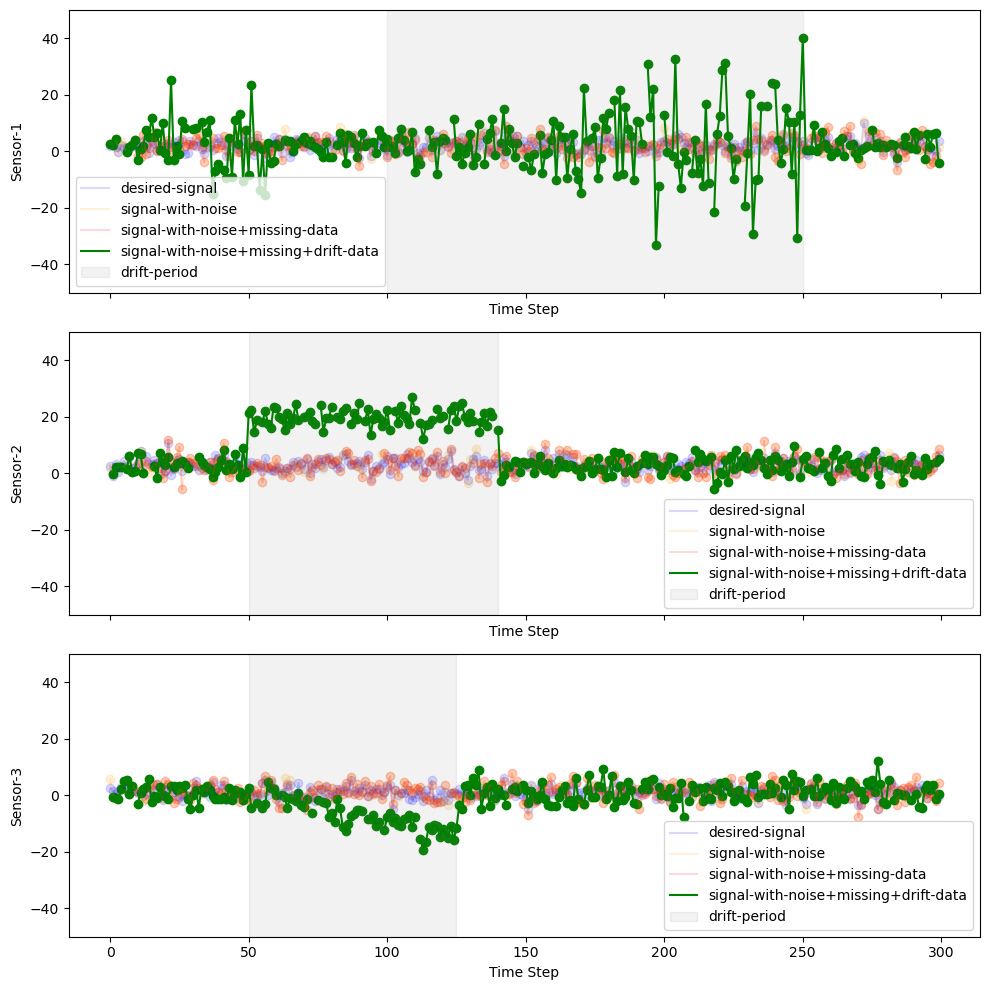

In [ ]:
drift_obs_data_stream = np.array([list_type_drift_obs_1, list_type_drift_obs_2, list_type_drift_obs_3])

drift_levels = {"signal": obs_data_stream,
                    f"noise-level-{NOISE_LEVEL}": noisy_obs_data_stream,
                    f"missing-data-{MISSING_DATA_PERCENTAGE}": missing_obs_data_stream,
                    "drift-data":drift_obs_data_stream}

drift_duration = {f"sensor-1": [drift_events_sens_1[i]["drift-event"] for i in range(len(drift_events_sens_1))],
                     f"sensor-2": [drift_events_sens_2[i]["drift-event"] for i in range(len(drift_events_sens_2))],
                    f"sensor-3": [drift_events_sens_3[i]["drift-event"] for i in range(len(drift_events_sens_3))]}

TRANSPARENCY=0.15
fig, axes = plt.subplots(nrows=len(obs_data_stream), ncols=1, figsize=(10, 10), sharex=True)
for idx, ax in enumerate(axes):
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels["signal"][idx], alpha=TRANSPARENCY , color="blue", label="desired-signal")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels["signal"][idx], alpha=TRANSPARENCY , color="blue")
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels[f"noise-level-{NOISE_LEVEL}"][idx], alpha=TRANSPARENCY , color="orange", label="signal-with-noise")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels[f"noise-level-{NOISE_LEVEL}"][idx], alpha=TRANSPARENCY , color="orange")
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels[f"missing-data-{MISSING_DATA_PERCENTAGE}"][idx], alpha=TRANSPARENCY, color="red", label="signal-with-noise+missing-data")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels[f"missing-data-{MISSING_DATA_PERCENTAGE}"][idx], alpha=TRANSPARENCY, color="red")
    ax.plot(np.arange(len(obs_data_stream[idx])), drift_levels["drift-data"][idx], color="green", label="signal-with-noise+missing+drift-data")
    ax.scatter(np.arange(len(obs_data_stream[idx])), drift_levels["drift-data"][idx], color="green")
    
    for drift_event in drift_duration[f"sensor-{idx + 1}"]:
        t0_drift = drift_event.t0_drift
        duration_drift = drift_event.duration_drift
        ax.axvspan(t0_drift, t0_drift + duration_drift, color='gray', alpha=0.1, label='drift-period' if idx == 0 else "")

    ax.set_ylabel(f"Sensor-{idx + 1}")
    ax.set_xlabel("Time Step")
    ax.set_ylim(-50, 50)
    ax.legend()
plt.tight_layout()
plt.show()

In [20]:
drift_duration

{'sensor-1': DriftParams(t0_drift=100, mu_drift=None, sigma_drift=20, duration_drift=150, drift_type='sigma-gradual'),
 'sensor-2': DriftParams(t0_drift=50, mu_drift=20, sigma_drift=None, duration_drift=90, drift_type='mean-sudden'),
 'sensor-3': DriftParams(t0_drift=50, mu_drift=-15, sigma_drift=None, duration_drift=75, drift_type='mean-gradual')}